<a href="https://colab.research.google.com/github/vivekvj18/ML_PROJECT/blob/main/ML_PROJECT(91_212).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sb
from xgboost import XGBClassifier,XGBRegressor
import gc
import warnings
warnings.filterwarnings("ignore")

## Parameters

In [5]:
RAND_VAL=42
num_folds=5

## Read Source Files

In [6]:
# df_train=pd.read_csv("/kaggle/input/playground-series-s4e2/train.csv")
# df_test=pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv")
# df_train.head()

# Upload kaggle.json
from google.colab import files
files.upload()

# Setup Kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle -q

# Download and unzip competition data
!kaggle competitions download -c ait-511-course-project-1-obesity-risk
!unzip -q ait-511-course-project-1-obesity-risk.zip -d data

# Load datasets
import pandas as pd
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
# sample_sub = pd.read_csv('data/sample_submission.csv')
df_train.head()

# !pip install lightgbm xgboost catboost scikit-learn seaborn
# !kaggle competitions submit -c ait-511-course-project-1-obesity-risk -f submission.csv -m "My first submission"

Saving kaggle.json to kaggle.json
  0% 0.00/570k [00:00<?, ?B/s]
100% 570k/570k [00:00<00:00, 790MB/s]


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [7]:
# # Download and unzip the original dataset
# !kaggle datasets download -d aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster
# !unzip -q obesity-or-cvd-risk-classifyregressorcluster.zipn -d data

# # Load the original dataset
# df_train_orig=pd.read_csv("data/ObesityDataSet.csv")
# df_train_orig['id']=-9999
# df_train_orig=df_train_orig[df_train.columns]
# df_train_orig.head()

!kaggle datasets download -d aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster
!unzip -q obesity-or-cvd-risk-classifyregressorcluster.zip -d data

# ===============================
# STEP 3: Load the dataset
# ===============================y
import pandas as pd

df_train_orig = pd.read_csv("data/ObesityDataSet.csv")
df_train_orig.rename(columns={'NObeyesdad': 'WeightCategory'}, inplace=True)

df_train_orig.head()

Dataset URL: https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster
License(s): CC-BY-SA-4.0
  0% 0.00/57.5k [00:00<?, ?B/s]
100% 57.5k/57.5k [00:00<00:00, 193MB/s]


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


### Merge Files

In [8]:
df_train['typ']=0
df_train_orig['typ']=0
df_test['typ']=1
#
df_all=pd.concat([df_train,df_train_orig,df_test],axis=0)

## Feature Engineering

In [9]:
cat_feats = df_all.columns[np.where(df_all.dtypes == "object")[0]].drop('WeightCategory')
num_feats  = df_all.columns[np.where(df_all.dtypes != "object")[0]].drop(['id','typ'])
##
df_all=pd.get_dummies(df_all,columns=cat_feats)
sc=StandardScaler()
df_all[num_feats]=sc.fit_transform(df_all[num_feats])

In [10]:
df_train = df_all[df_all.typ==0].reset_index(drop=True)
df_test = df_all[df_all.typ==1].reset_index(drop=True)
##
print(len(df_train))
print(len(df_test))
##
feat_cols=df_train.columns.drop(['id','typ','WeightCategory'])
X_test=df_test[feat_cols]
##
print(feat_cols)
df_train.head()

17644
5225
Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Gender_Female', 'Gender_Male', 'family_history_with_overweight_no',
       'family_history_with_overweight_yes', 'FAVC_no', 'FAVC_yes',
       'CAEC_Always', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no',
       'SMOKE_no', 'SMOKE_yes', 'SCC_no', 'SCC_yes', 'CALC_Always',
       'CALC_Frequently', 'CALC_Sometimes', 'CALC_no', 'MTRANS_Automobile',
       'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation',
       'MTRANS_Walking'],
      dtype='object')


,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,WeightCategory,...,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0.0,0.096944,-0.004315,-0.231290,-0.831454,0.321249,1.208977,-1.172655,0.590412,Overweight_Level_II,...,False,False,False,True,False,False,False,False,True,False
1,1.0,-1.022938,-1.597389,-1.167046,-0.831454,0.344685,-0.045069,0.018605,0.629439,Normal_Weight,...,False,False,False,False,True,True,False,False,False,False
2,2.0,-1.022938,0.126115,-1.426276,-1.055460,-1.883916,-0.192259,-0.140970,1.746797,Insufficient_Weight,...,False,False,False,False,True,False,False,False,True,False
3,3.0,-0.509713,0.117808,1.650273,1.043604,0.344685,-0.580372,0.575951,0.264828,Obesity_Type_III,...,False,False,False,True,False,False,False,False,True,False
4,4.0,1.348066,2.432987,0.228741,0.442955,-1.098466,-0.078166,1.171712,0.516176,Overweight_Level_II,...,False,False,False,True,False,False,False,False,True,False


In [11]:
X=df_train[feat_cols]
y=df_train['WeightCategory']
#
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [12]:
xgb_params ={
    'learning_rate': 0.026,
    'n_estimators': 1500,
    'objective':'multi:softprob',
    'eval_metric':'mlogloss',
    'early_stopping_rounds':60,
    'max_depth': 19,
    'min_child_weight': 11.7,
    'gamma': 0.40,
    'colsample_bytree': 0.46,
    'random_state':RAND_VAL,
    'subsample': 0.82,
    'reg_alpha': 0.0004,
    'verbosity': 0,
    'reg_lambda': 1.4,
}

## Training

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


XGB=XGBClassifier(**xgb_params)
XGB.fit(X_train,y_train, eval_set=[(X_val, y_val)],verbose=200)

y_pred_val = XGB.predict(X_val[feat_cols])
y_pred_val = y_pred_val.astype('int')
acc_val = accuracy_score(y_val, y_pred_val)
print("Accuracy : ",acc_val)

[0]	validation_0-mlogloss:1.89922
[200]	validation_0-mlogloss:0.30052
[400]	validation_0-mlogloss:0.24002
[600]	validation_0-mlogloss:0.23036
[800]	validation_0-mlogloss:0.22832
[1000]	validation_0-mlogloss:0.22769
[1185]	validation_0-mlogloss:0.22743
Accuracy :  0.9193426520589346


## Classification Report

In [14]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       643
           1       0.89      0.90      0.90       790
           2       0.92      0.90      0.91       768
           3       0.97      0.98      0.98       810
           4       1.00      1.00      1.00       992
           5       0.83      0.81      0.82       640
           6       0.83      0.85      0.84       651

    accuracy                           0.92      5294
   macro avg       0.91      0.91      0.91      5294
weighted avg       0.92      0.92      0.92      5294



## Confusion Matrix

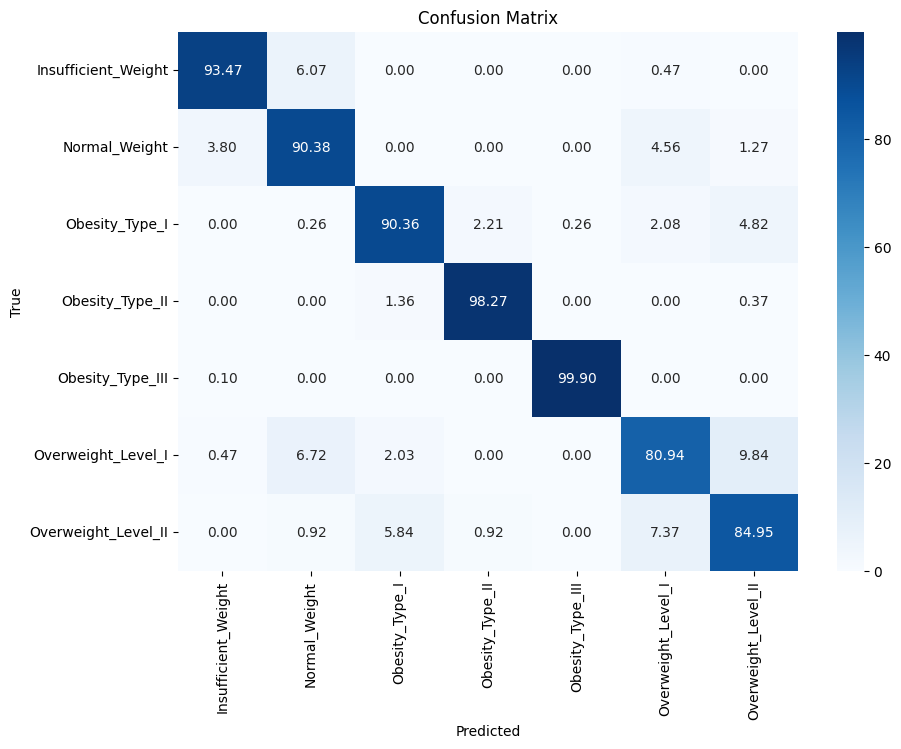

In [15]:
cm = confusion_matrix(y_val, y_pred_val)
cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sb.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
          xticklabels=label_encoder.classes_,yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Submission

In [16]:
y_test = XGB.predict(df_test[feat_cols])
y_test

array([4, 5, 6, ..., 2, 6, 3])

In [17]:
y_test=label_encoder.inverse_transform(y_test)
submission = df_test[['id']]
submission['NObeyesdad']=y_test
submission.to_csv("submission.csv", index=False)
submission.head()

,id,NObeyesdad
0,15533.0,Obesity_Type_III
1,15534.0,Overweight_Level_I
2,15535.0,Overweight_Level_II
3,15536.0,Obesity_Type_II
4,15537.0,Normal_Weight
